In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os

torch.manual_seed(2020) 
np.random.seed(2020)
random.seed(2020)

embedding_dims =7
batch_size = 18
epochs =50

train_df = pd.read_csv("C:/Users/1315/Desktop/data/val_ck.csv")
test_df = pd.read_csv("C:/Users/1315/Desktop/data/test_ck.csv")

print(train_df.shape)
print(test_df.shape)

(800, 3)
(181, 3)


In [2]:
from PIL import Image

class ImageData(Dataset):
        

    def __init__(self, df, train =True, transform =None):
        self.is_train =train
        self.transform = transform 
        self.to_pil = transforms.ToPILImage() ## torch에서 이미지 처리 

        
        if self.is_train:

            self.images = df['pixels']
            self.labels = df['emotion']
            self.index = df.index.values
        
        else:
            self.images = df['pixels']
            self.labels = df['emotion']
            self.index = df.index.values 
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item): 

        imgarray_str = self.images[item].split(' ')
        imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48,1)
        anchor_img = imgarray
        
        if self.is_train:
            anchor_label = self.labels[item]
            
            ## 해당 anchor가 아닌 것들중에서 Label 같은 것들의 index를 가지고 옮
            positive_list = self.index[self.index != item][self.labels[self.index!=item]==anchor_label]
            
            positive_item = random.choice(positive_list)
            imgarray_str = self.images[positive_item].split(' ')
            imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48,1) 
            positive_img =imgarray
            
            ## 해당 anchor가 아닌 것들중에서 Label 다른 것들의 index를 가지고 옮
            negative_list = self.index[self.index != item][self.labels[self.index!=item]!=anchor_label]
            
            nagative_item = random.choice(negative_list)
            imgarray_str = self.images[nagative_item].split(' ')
            imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48,1) 
            negative_img = imgarray
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img            
            

train_ds = ImageData(train_df, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)


test_ds = ImageData(test_df, train=False, transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0) 

In [3]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1-x2).pow(2).sum(1) 
    
    def forward(self,  anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [4]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=7, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.Resnet18 = resnet18()
        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(10,50)
        self.fc2 = nn.Linear(50,7)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = F.dropout(xs)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
       
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
   
        return x

    def forward(self,input):
        out = self.stn(input)
        out = self.Resnet18(out)
        # out = F.dropout(out)
        # out = F.relu(self.fc1(out))
        # out = self.fc2(out)
        
        return out

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [7]:
## Create instance

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Network().to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = TripletLoss()
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    

model.train()
for epoch in range(epochs):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(train_loader):
        anchor_img, positive_img, negative_img, anchor_label = anchor_img.to(device), positive_img.to(device),negative_img.to(device), anchor_label.to(device)
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
             
        running_loss.append(loss.detach().cpu().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

C:\Users\1315\anaconda3\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\1315\anaconda3\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Epoch: 1/50 - Loss: 0.6973
Epoch: 2/50 - Loss: 0.3734
Epoch: 3/50 - Loss: 0.3706
Epoch: 4/50 - Loss: 0.4289
Epoch: 5/50 - Loss: 0.3241
Epoch: 6/50 - Loss: 0.2454
Epoch: 7/50 - Loss: 0.1830
Epoch: 8/50 - Loss: 0.1309
Epoch: 9/50 - Loss: 0.1183
Epoch: 10/50 - Loss: 0.1341
Epoch: 11/50 - Loss: 0.1056
Epoch: 12/50 - Loss: 0.0847
Epoch: 13/50 - Loss: 0.0794
Epoch: 14/50 - Loss: 0.0486
Epoch: 15/50 - Loss: 0.1143
Epoch: 16/50 - Loss: 0.0536
Epoch: 17/50 - Loss: 0.0419
Epoch: 18/50 - Loss: 0.0385
Epoch: 19/50 - Loss: 0.0344
Epoch: 20/50 - Loss: 0.0291
Epoch: 21/50 - Loss: 0.0517
Epoch: 22/50 - Loss: 0.0346
Epoch: 23/50 - Loss: 0.0251
Epoch: 24/50 - Loss: 0.0286
Epoch: 25/50 - Loss: 0.0293
Epoch: 26/50 - Loss: 0.0137
Epoch: 27/50 - Loss: 0.0373
Epoch: 28/50 - Loss: 0.0478
Epoch: 29/50 - Loss: 0.0278
Epoch: 30/50 - Loss: 0.0501
Epoch: 31/50 - Loss: 0.0552
Epoch: 32/50 - Loss: 0.0498
Epoch: 33/50 - Loss: 0.0185
Epoch: 34/50 - Loss: 0.0227
Epoch: 35/50 - Loss: 0.0221
Epoch: 36/50 - Loss: 0.0211
E

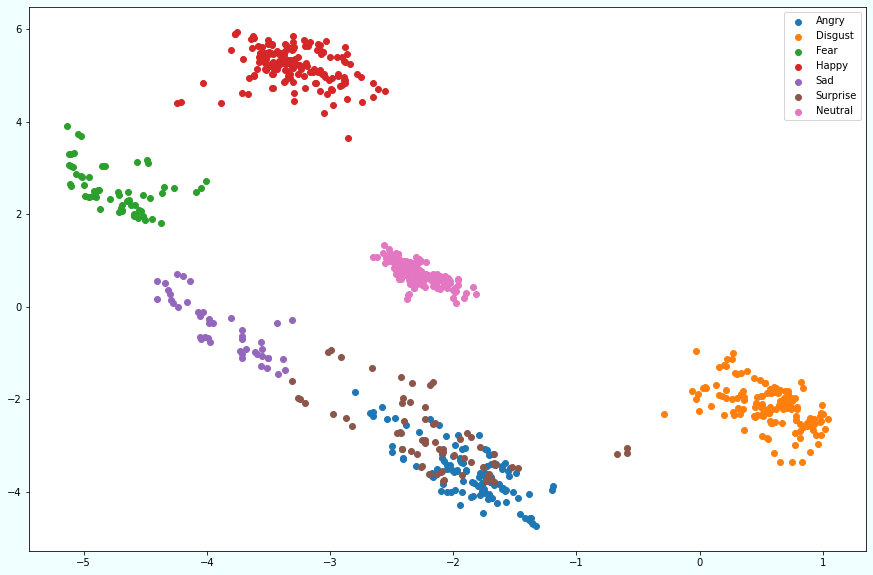

In [8]:
train_results =[]
labels =[]
classes=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
model.eval()
with torch.no_grad():
    for img, _, _, label in train_loader:
        img,label = img.to(device),label.to(device)
        train_results.append(model(img).cpu().numpy())
        labels.append(label.cpu())
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

## visualization
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=classes[label])

plt.legend()
plt.show()

C:\Users\1315\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


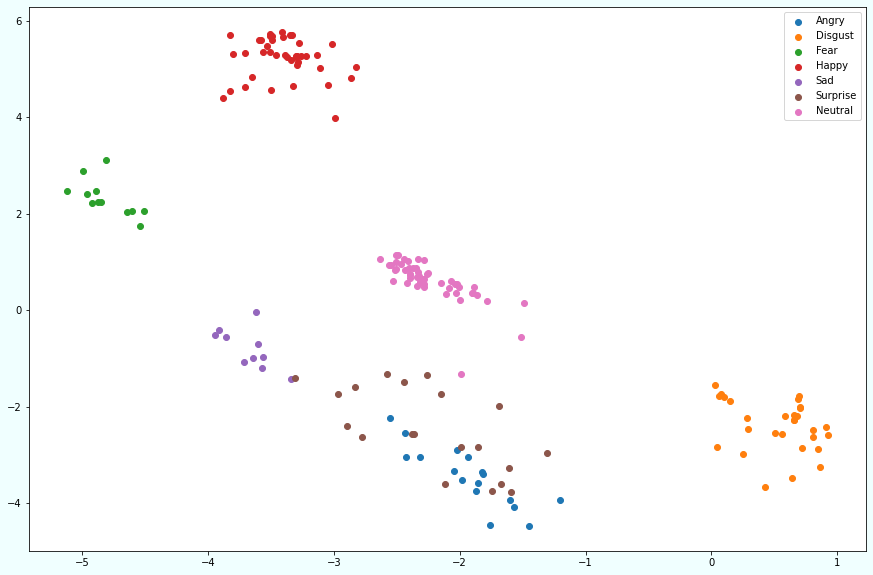

Accuracy :99.4475138121547%


In [9]:
tree = XGBClassifier(seed=2020)
tree.fit(train_results, labels)

test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for img in test_loader:
        img = img.to(device)
        test_results.append(model(img).cpu().numpy())
        test_labels.append(tree.predict(model(img).cpu().numpy()))
        
test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)


plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(test_labels):        
   
    tmp = test_results[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=classes[label])

plt.legend()
plt.show()

# accuracy 
true_=(tree.predict(test_results)==test_labels).sum()
len_ = len(test_labels)
print("Accuracy :{}%".format((true_/len_)*100)) ##100%